In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
from astropy.convolution import convolve, Box1DKernel
from scipy.interpolate import interp1d


import astropy.units as u
from astropy import time, coordinates as coord
import astropy.constants as const
from astropy.modeling import models, fitting


#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [2]:
path = '/media/david/2tb_ext_hd/hddata/meats/hst/kepler-51/'
x1ds = np.hstack((glob.glob('{}*0_x1d.fits'.format(path)), glob.glob('{}*sx1.fits'.format(path)), glob.glob('{}*x1dsum.fits'.format(path))))
x1ds

array(['/media/david/2tb_ext_hd/hddata/meats/hst/kepler-51/oeoo37010_x1d.fits',
       '/media/david/2tb_ext_hd/hddata/meats/hst/kepler-51/oeoo37020_x1d.fits',
       '/media/david/2tb_ext_hd/hddata/meats/hst/kepler-51/oeoo37030_sx1.fits'],
      dtype='<U69')

/media/david/2tb_ext_hd/hddata/meats/hst/kepler-51/oeoo37010_x1d.fits
G230L
512.5828


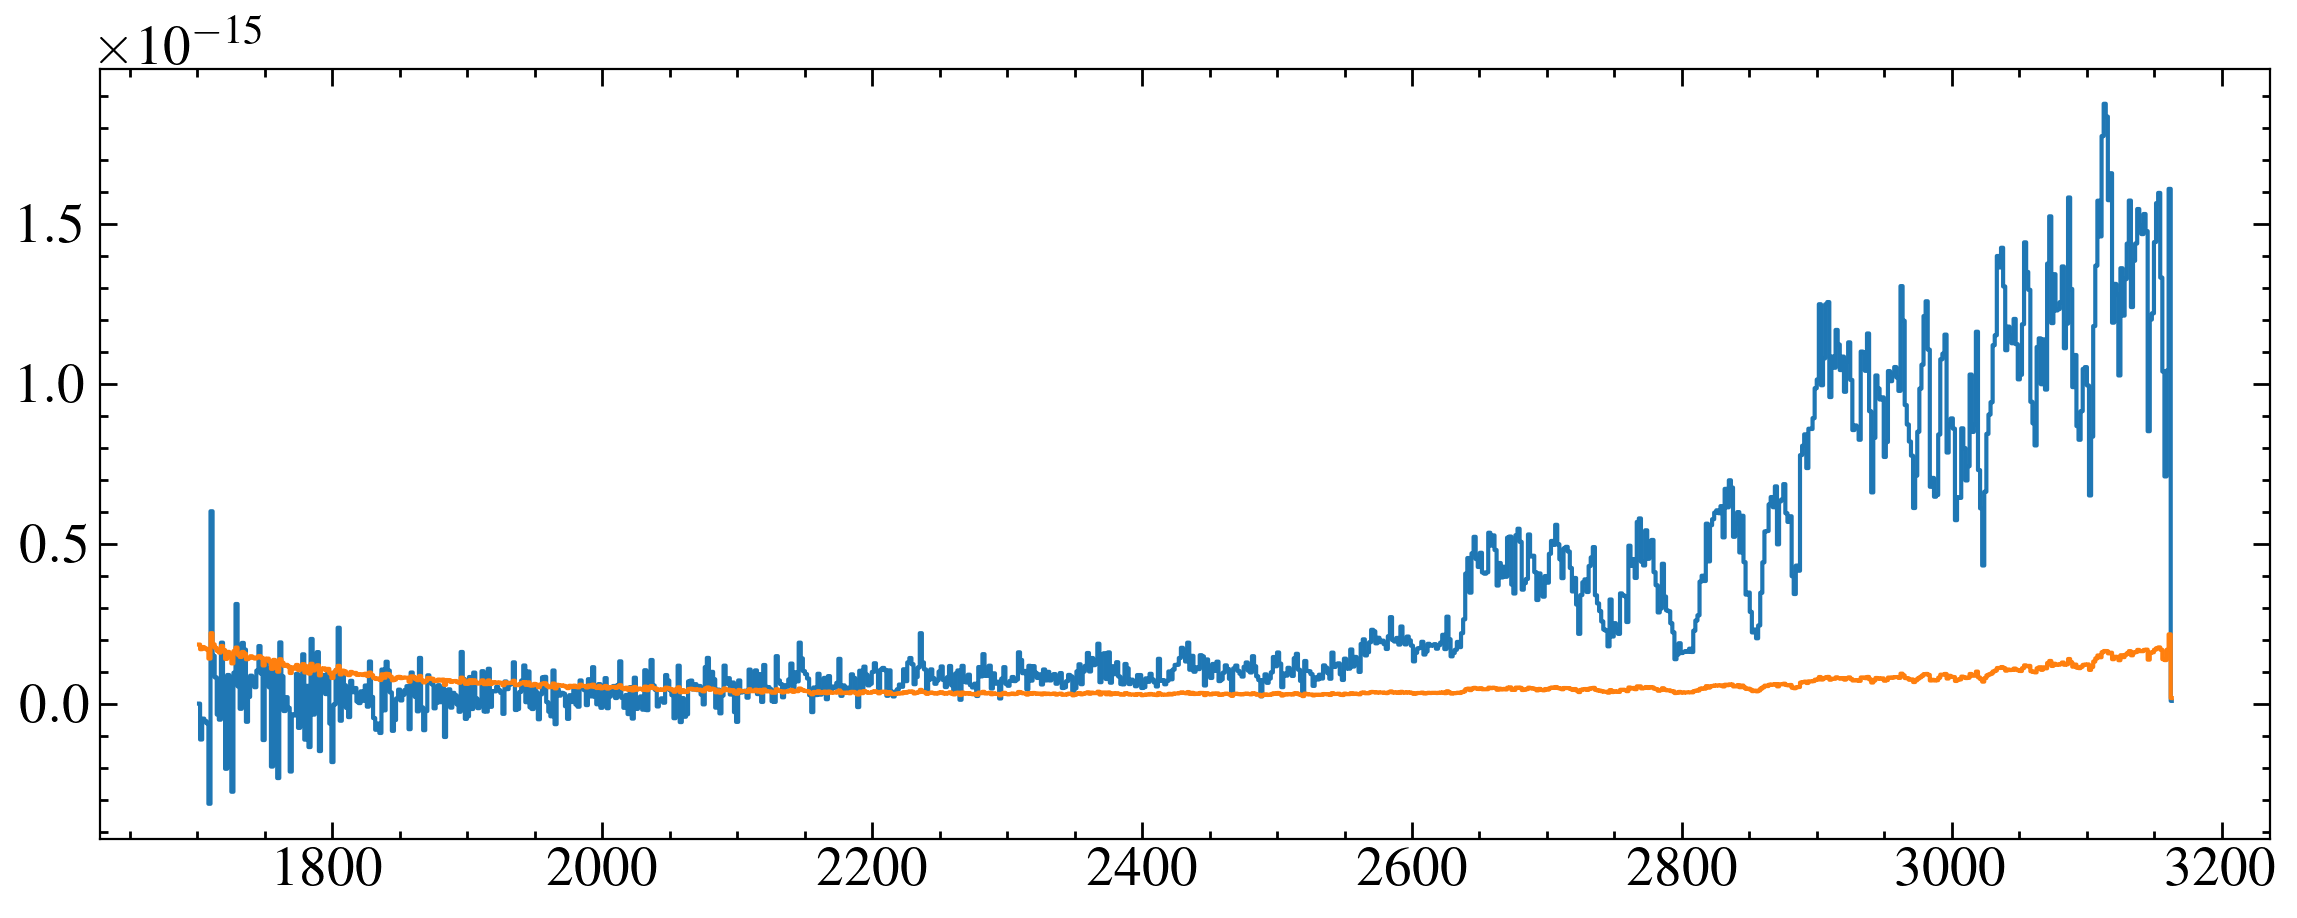

/media/david/2tb_ext_hd/hddata/meats/hst/kepler-51/oeoo37020_x1d.fits
G230L
512.6981


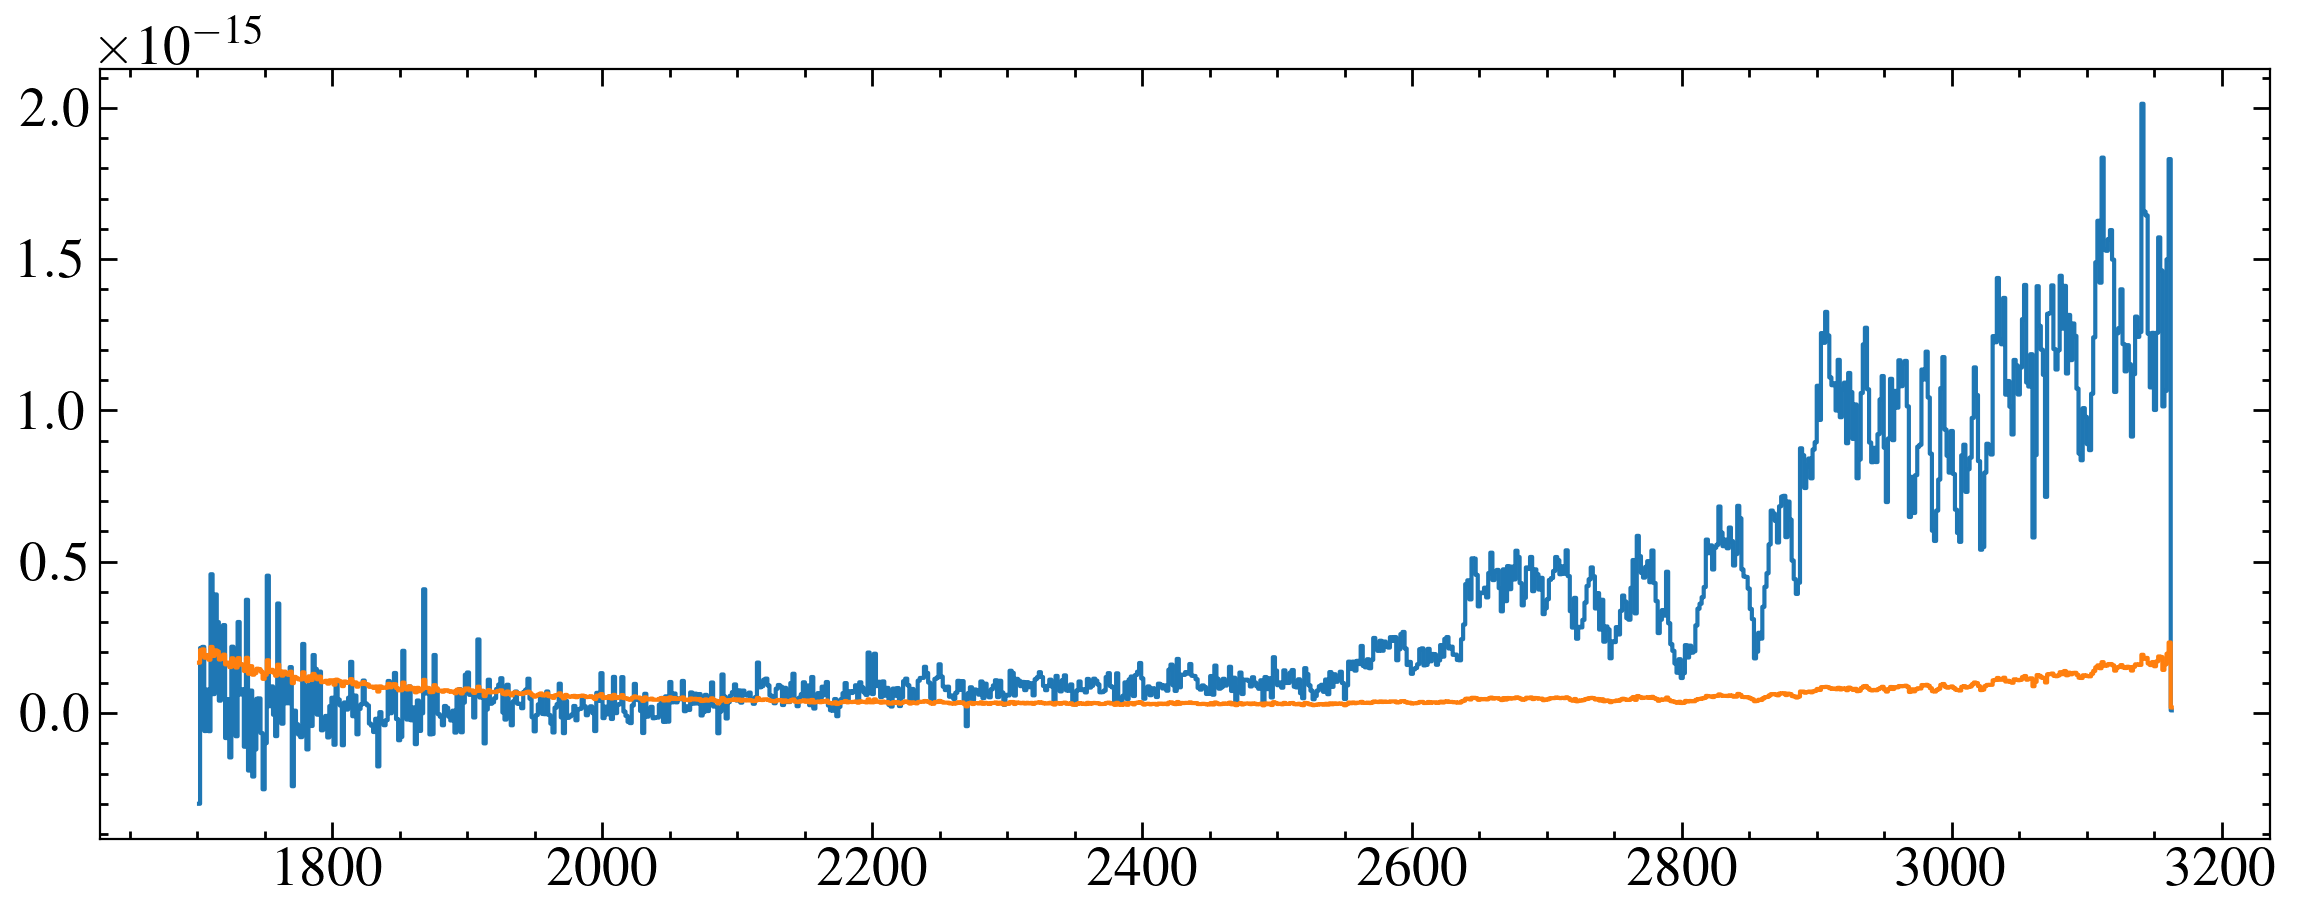

/media/david/2tb_ext_hd/hddata/meats/hst/kepler-51/oeoo37030_sx1.fits
G430L
894.01575


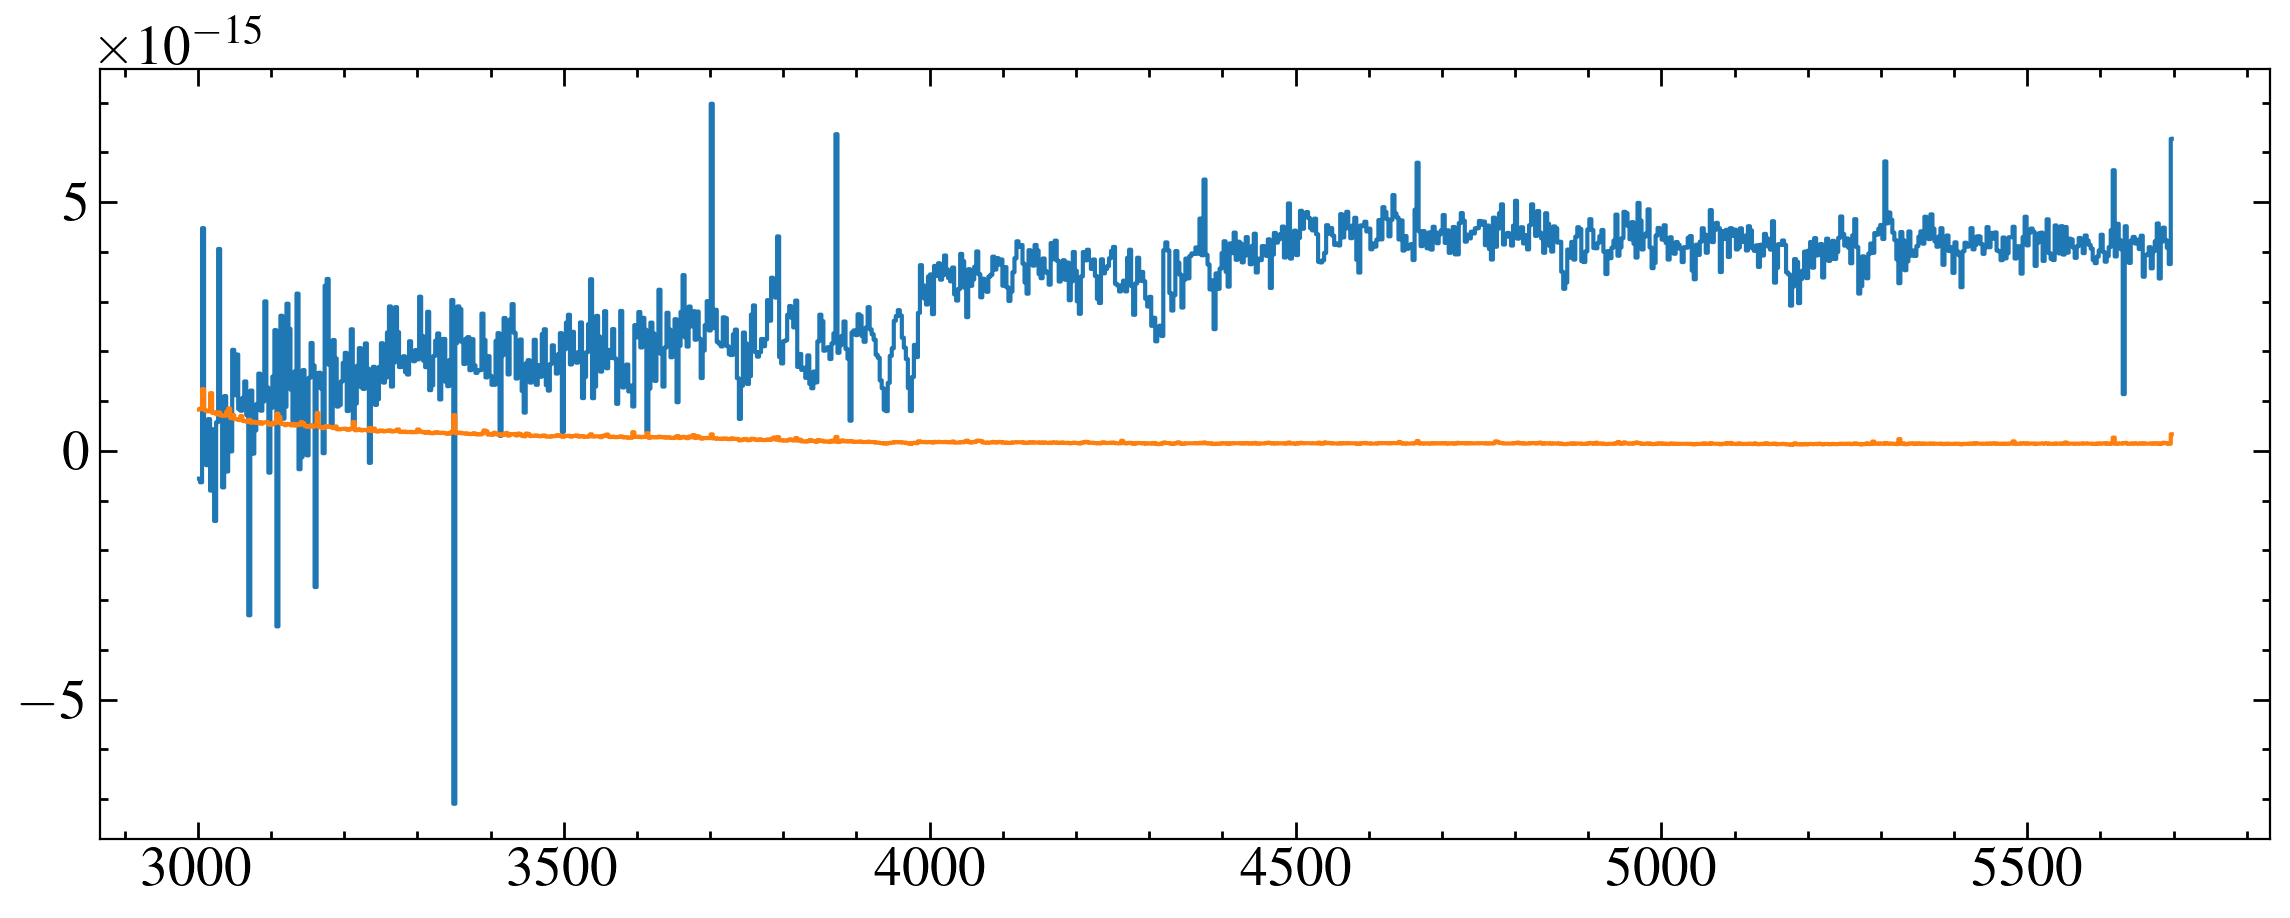

In [28]:
for x in x1ds:
    print(x)
    grating = fits.getheader(x, 0)['OPT_ELEM'] 
    print(grating)
    data = fits.getdata(x, 1)[0]
    # if x != x1ds:
    print(data['A2Center'])
    w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
    if grating in ['G140M', 'G140L']:
        mask = (w > 1160)
    if grating =='G230L':
        mask = (w > 1700)
    if grating =='G430L':
        mask = (w > 3000)
    
    w, f, e = w[mask], f[mask], e[mask]
    plt.step(w, f, where='mid')
    plt.step(w, e, where='mid')
    plt.show()
    

In [5]:
def spectra_adder(f_array, e_array, scale_correct=True):
    """
    Returns a variance-weighted coadd with standard error of the weighted mean (variance weights, scale corrected).
    f_array and e_arrays are collections of flux and error arrays, which should have the same lenth and wavelength scale
    """
    weights = 1 / (e_array**2)
    flux = np.average(f_array, axis =0, weights = weights)
    var = 1 / np.sum(weights, axis=0)
    rcs = np.sum((((flux - f_array)**2) * weights), axis=0) / (len(f_array)-1) #reduced chi-squared
    if scale_correct:
        error = (var * rcs)**0.5
    else:
        error = var**2
    return flux,error

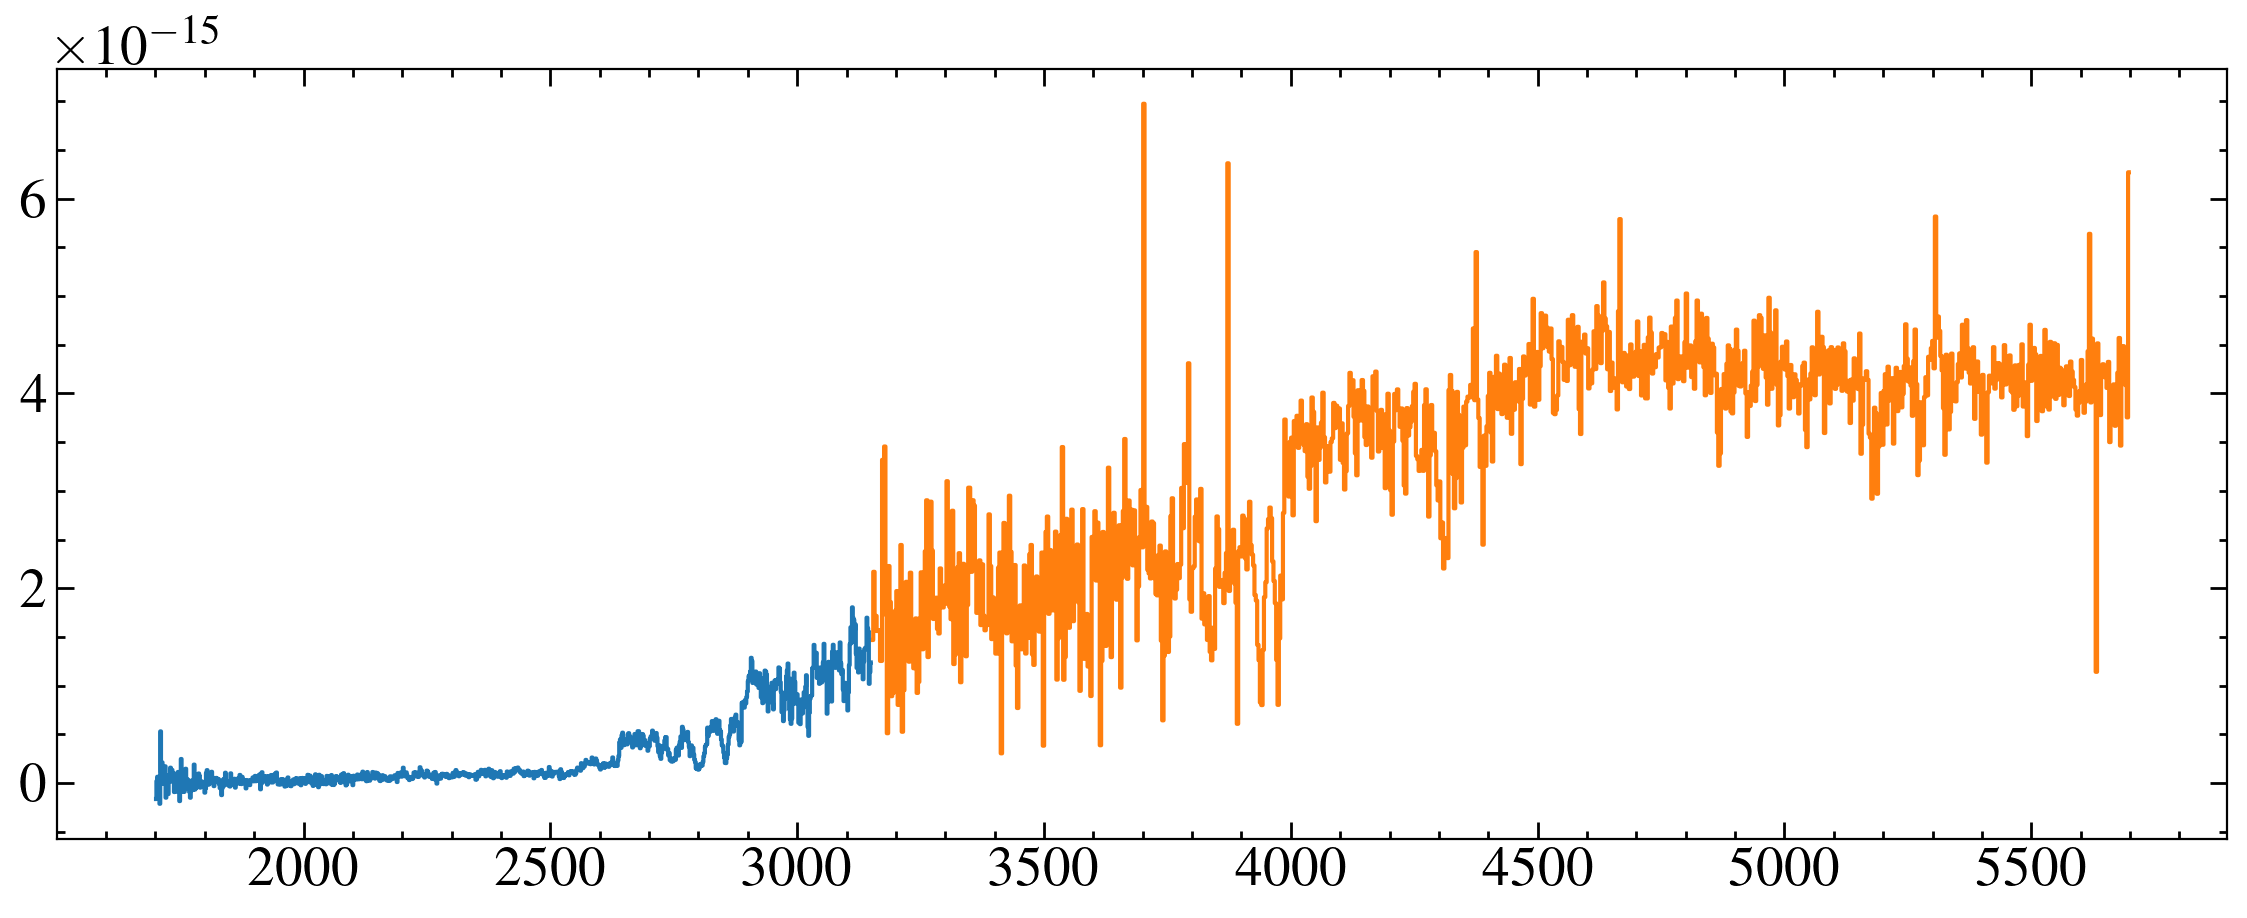

In [22]:
w_nuv = []
f_nuv = []
e_nuv = []

n=0
for x in x1ds:
    data = fits.getdata(x, 1)[0]
    w, f, e , dq = data['WAVELENGTH'], data['FLUX'], data['ERROR'], data['DQ']
    grating = fits.getheader(x, 0)['OPT_ELEM']
    if grating == 'G230L':
        mask = (w > 1700) & (w < 3150)
        w, f, e = w[mask], f[mask], e[mask]
        if n == 0:
            w_nuv = w
            f_nuv.append(f)
            e_nuv.append(e)
        else:
            f_nuv.append(interp1d(w, f, fill_value='extrapolate')(w_nuv))
            e_nuv.append(interp1d(w, e, fill_value='extrapolate')(w_nuv))            
        n +=1
    elif grating == 'G430L':
        mask = (w > 3150) & (f >0)
        w_opt, f_opt, e_opt, dq_opt = w[mask], f[mask], e[mask], dq[mask]

f_nuv, e_nuv = spectra_adder(np.array(f_nuv), np.array(e_nuv), scale_correct=True)

plt.step(w_nuv, f_nuv, where='mid')
# plt.step(w_nuv, e_nuv, where='mid')
plt.step(w_opt, f_opt, where='mid', zorder=-1)

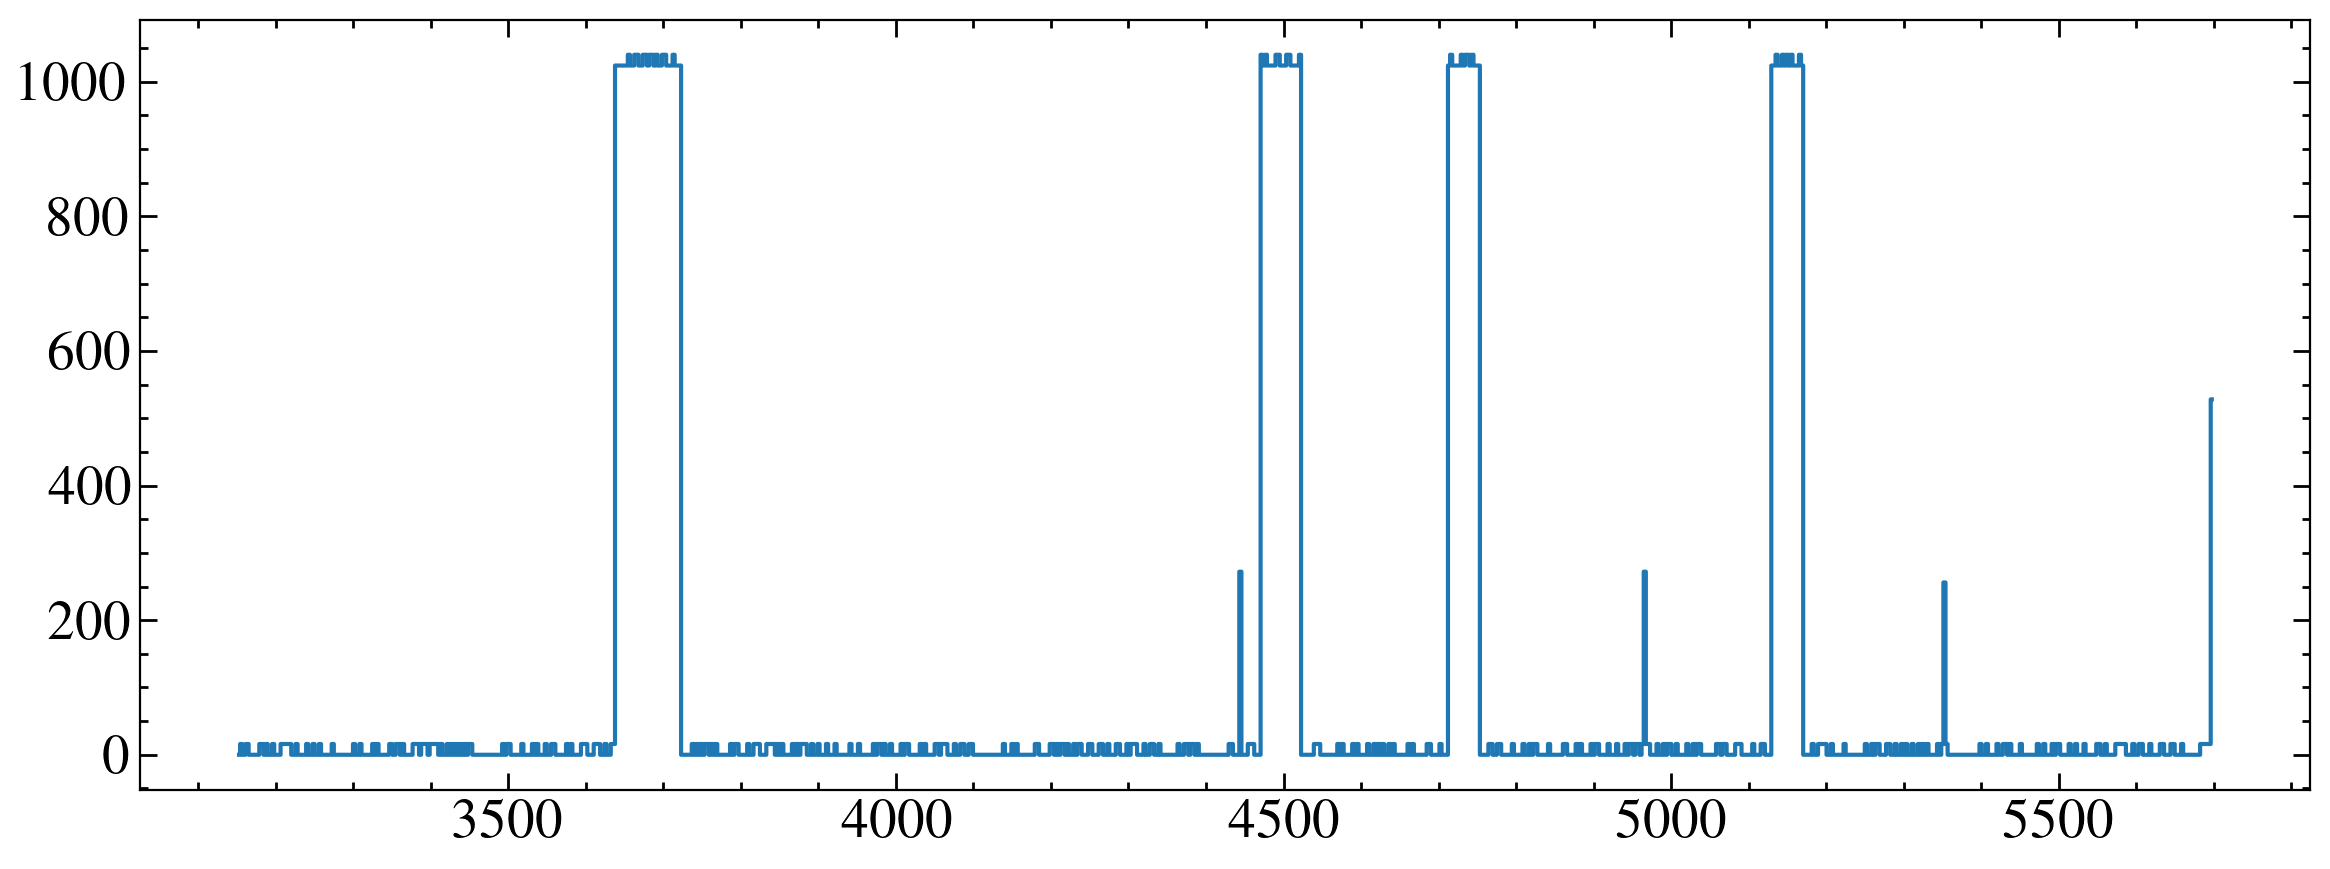

[   0   16  256  272  528 1024 1040]


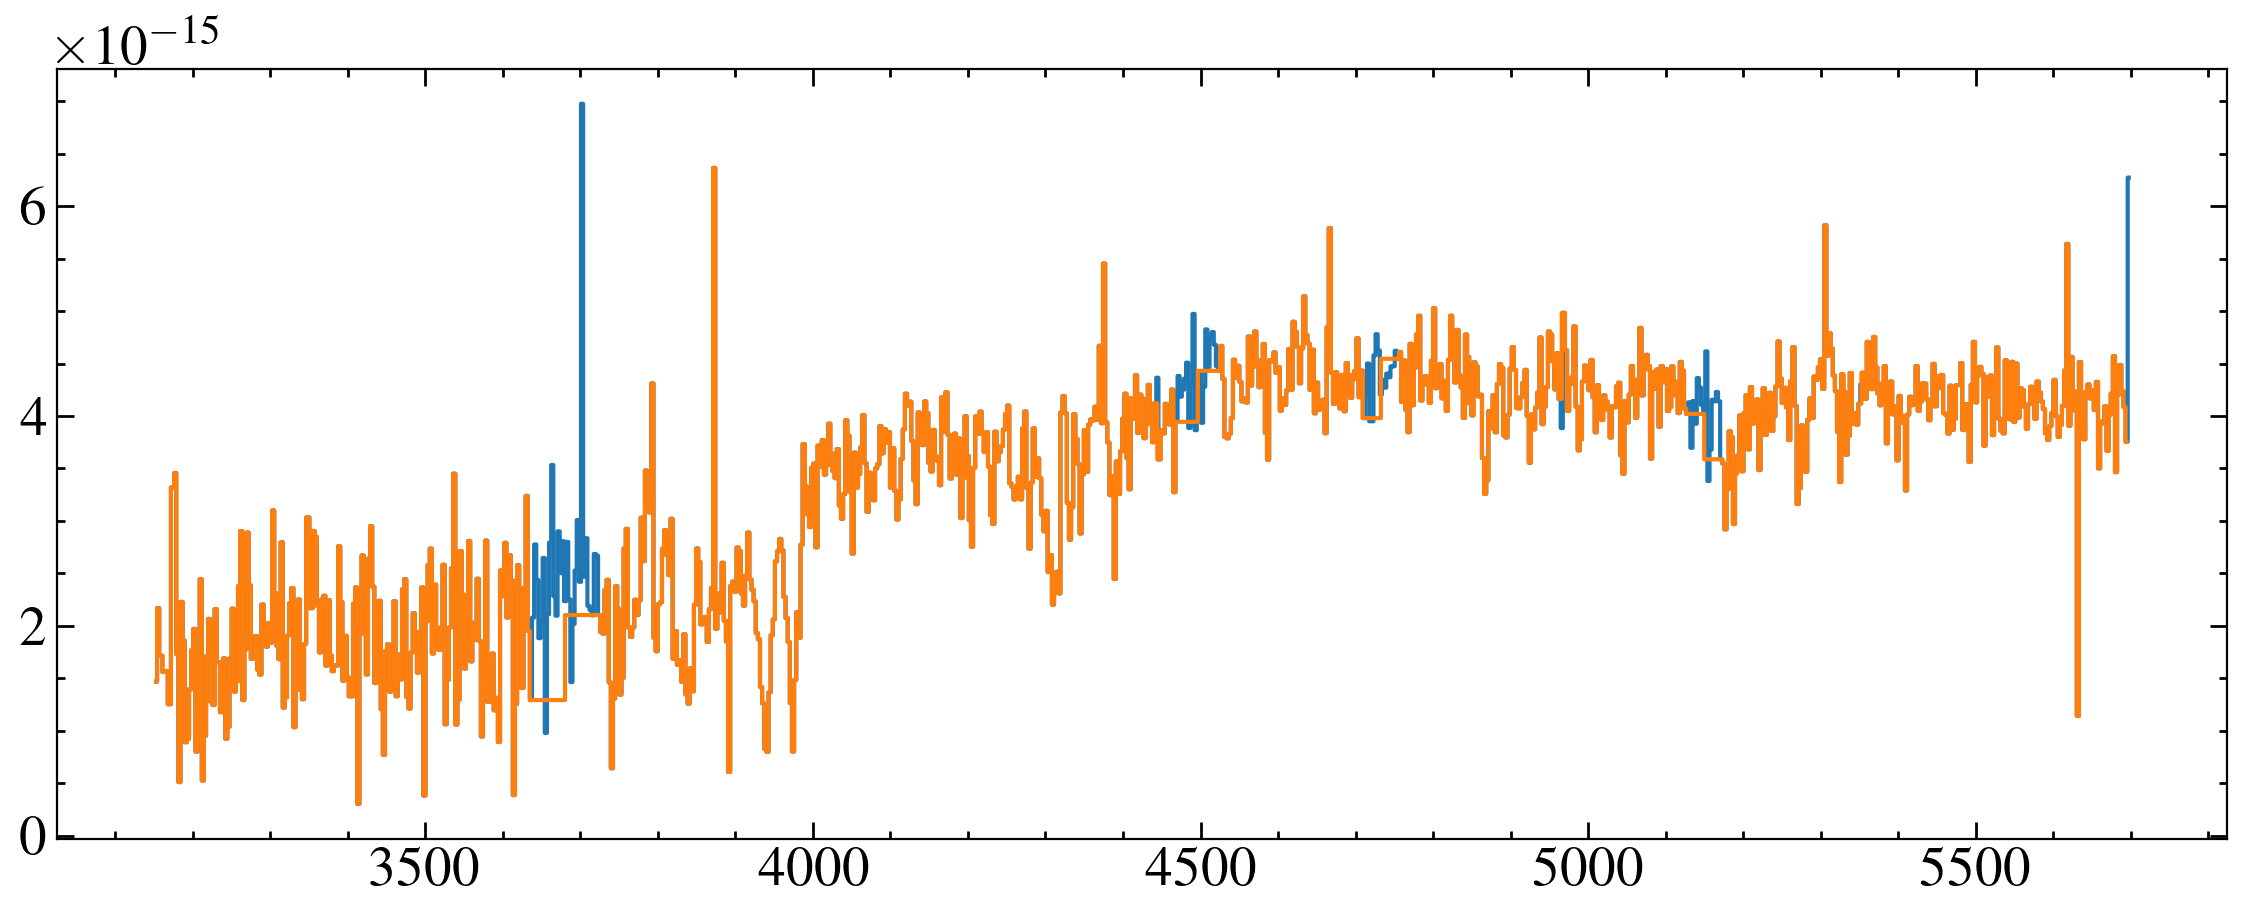

(array([840.,   0.,   3.,   0.,   0.,   1.,   0.,   0.,   0.,  80.]),
 array([   0.,  104.,  208.,  312.,  416.,  520.,  624.,  728.,  832.,
         936., 1040.]),
 <BarContainer object of 10 artists>)

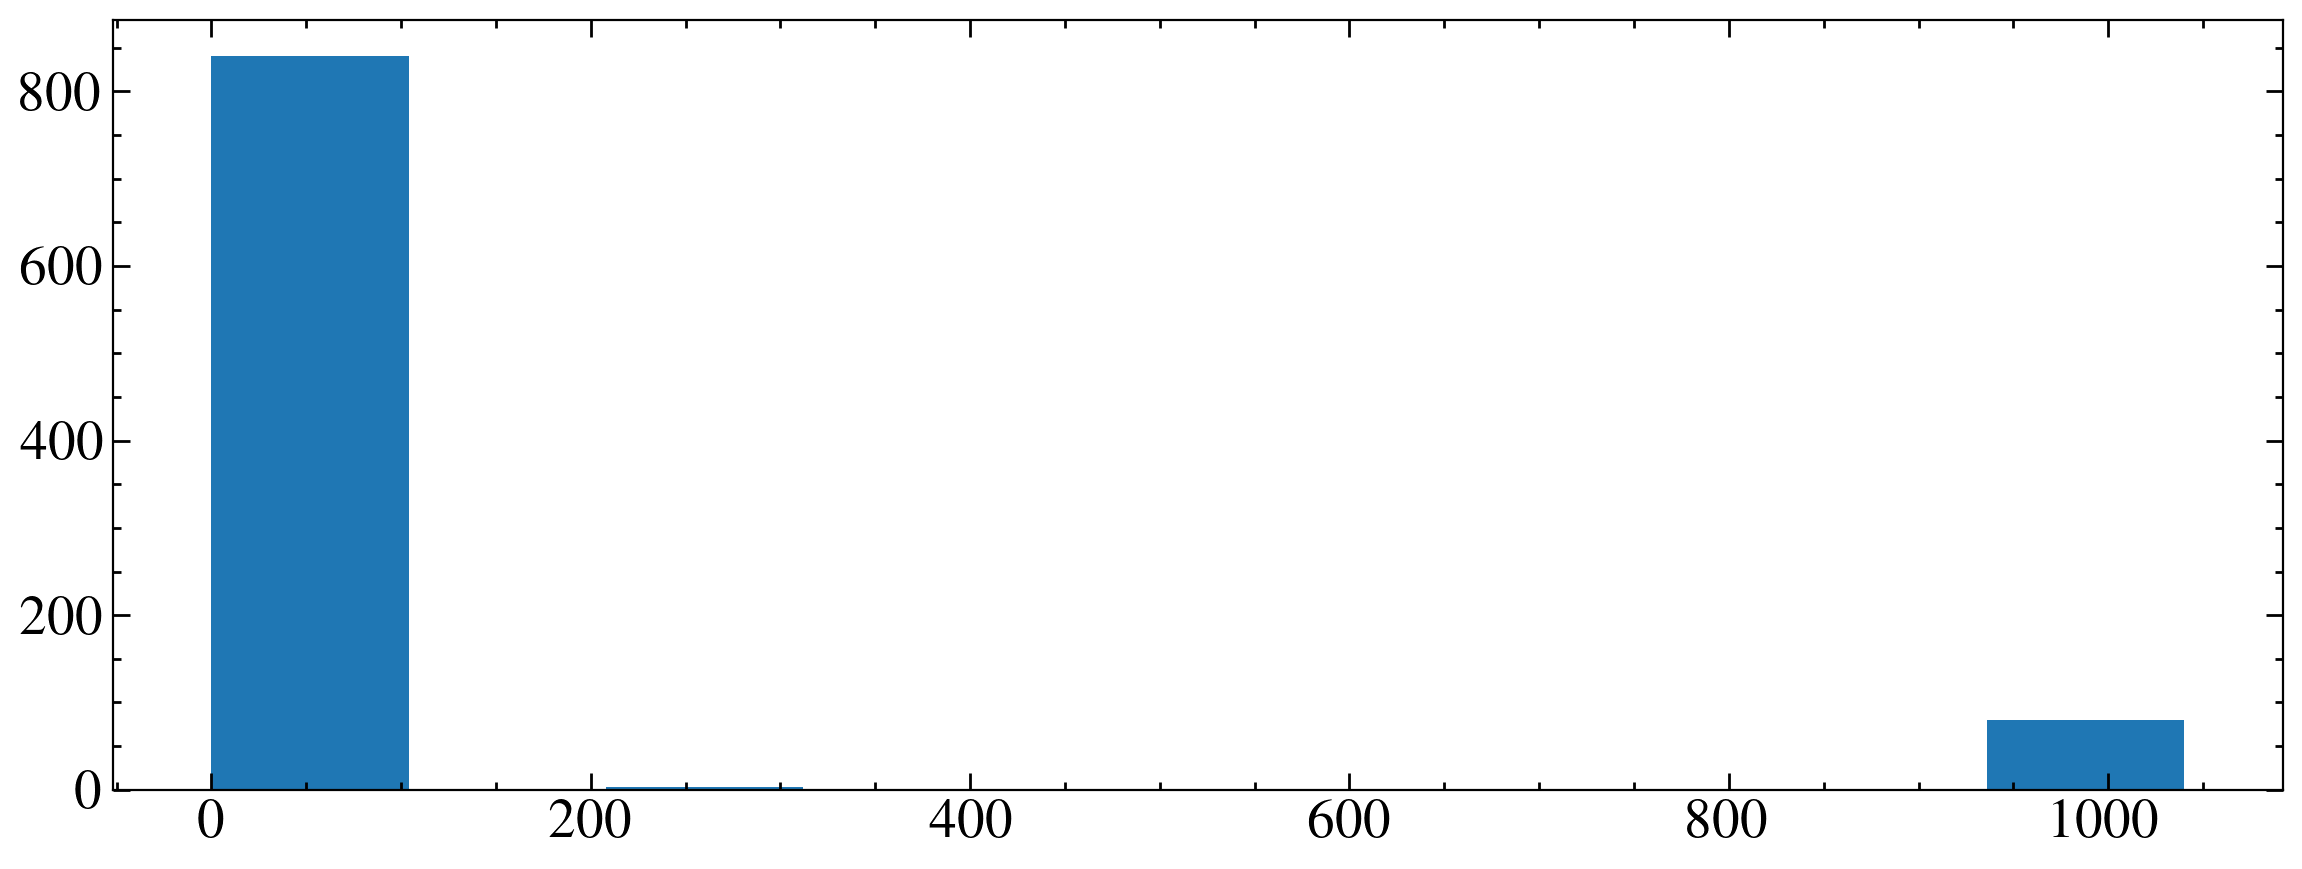

In [27]:
plt.step(w_opt, dq_opt, where='mid', zorder=-1)

plt.show()

plt.step(w_opt, f_opt, where='mid', zorder=-1)
plt.step(w_opt[dq_opt<=16], f_opt[dq_opt<=16], where='mid', zorder=-1)

print(np.unique(dq_opt))

plt.show()
plt.hist(dq_opt)